In [63]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, Activation, Concatenate
from keras.layers.convolutional import MaxPooling2D, Conv2D, UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator


In [8]:
df = pd.read_csv("understanding_cloud_organization/train.csv")

In [9]:
df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [10]:
df = df[~df['EncodedPixels'].isnull()].copy()

df['Image'] = df['Image_Label'].map(lambda x: x.split('_')[0])
df['Class'] = df['Image_Label'].map(lambda x: x.split('_')[1])

classes = df['Class'].unique()

# Group and reset index
df = df.groupby('Image')['Class'].agg(set).reset_index()

# Add columns for each class
for class_name in classes:
    df[class_name] = df['Class'].map(lambda x: 1 if class_name in x else 0)

df.head()


,Image,Class,Fish,Flower,Sugar,Gravel
0,0011165.jpg,"{Flower, Fish}",1,1,0,0
1,002be4f.jpg,"{Flower, Sugar, Fish}",1,1,1,0
2,0031ae9.jpg,"{Flower, Sugar, Fish}",1,1,1,0
3,0035239.jpg,"{Gravel, Flower}",0,1,0,1
4,003994e.jpg,"{Sugar, Gravel, Fish}",1,0,1,1


In [146]:
train_df.shape

(4436, 6)

In [12]:
dataset_path = os.path.join("understanding_cloud_organization","train_images")

In [149]:
test_df

,Image,Class,Fish,Flower,Sugar,Gravel
4443,cce531c.jpg,{Sugar},0,0,1,0
1365,3e5339e.jpg,"{Gravel, Sugar}",0,0,1,1
1775,5127b0e.jpg,"{Flower, Fish}",1,1,0,0
4486,cf38b60.jpg,"{Flower, Fish}",1,1,0,0
809,24681ee.jpg,"{Flower, Fish}",1,1,0,0
...,...,...,...,...,...,...
5329,f55bc0a.jpg,"{Gravel, Fish}",1,0,0,1
94,04fddf9.jpg,"{Gravel, Flower}",0,1,0,1
849,265e050.jpg,"{Gravel, Sugar}",0,0,1,1
3202,9203dd2.jpg,"{Sugar, Gravel, Fish}",1,0,1,1


In [39]:
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values
    return image

# Load training images
train_images = [load_and_preprocess_image(os.path.join(dataset_path, fname)) for fname in df["Image"]]
train_images = np.array(train_images)


# Prepare labels (assuming binary classification for each class, 1 if class is present, 0 otherwise)
train_labels = df[['Fish', 'Flower', 'Sugar', 'Gravel']].values

# Similarly load and prepare test images and labels
#test_images = [load_and_preprocess_image(os.path.join(dataset_path, fname)) for fname in test_df["Image"]]
#test_images = np.array(test_images)
# Prepare test labels here similarly as done for train_labels


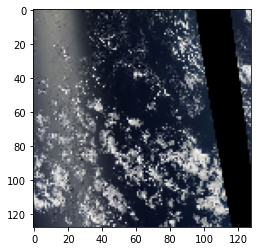

In [44]:
plt.imshow(train_images[2])

In [49]:
y = np.array(df.drop(['Image', 'Class'],axis=1))
y

array([[1, 1, 0, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       ...,
       [0, 0, 1, 0],
       [0, 1, 0, 1],
       [0, 1, 0, 0]], dtype=int64)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(train_images, y, random_state=42, test_size=0.1)


In [59]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='sigmoid'))
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_138 (Conv2D)         (None, 124, 124, 16)      1216      
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 62, 62, 16)       0         
 g2D)                                                            
                                                                 
 dropout_41 (Dropout)        (None, 62, 62, 16)        0         
                                                                 
 conv2d_139 (Conv2D)         (None, 58, 58, 32)        12832     
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 29, 29, 32)       0         
 g2D)                                                            
                                                                 
 dropout_42 (Dropout)        (None, 29, 29, 32)      

In [60]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [61]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=64)


Epoch 1/10
78/78 [==============================] - 102s 1s/step - loss: 0.6812 - accuracy: 0.2182 - val_loss: 0.6787 - val_accuracy: 0.1928
Epoch 2/10
78/78 [==============================] - 94s 1s/step - loss: 0.6734 - accuracy: 0.2168 - val_loss: 0.6627 - val_accuracy: 0.1928
Epoch 3/10
78/78 [==============================] - 92s 1s/step - loss: 0.6569 - accuracy: 0.2591 - val_loss: 0.6525 - val_accuracy: 0.2541
Epoch 4/10
78/78 [==============================] - 105s 1s/step - loss: 0.6352 - accuracy: 0.2921 - val_loss: 0.6240 - val_accuracy: 0.3207
Epoch 5/10
78/78 [==============================] - 102s 1s/step - loss: 0.6311 - accuracy: 0.2899 - val_loss: 0.6200 - val_accuracy: 0.2739
Epoch 6/10
78/78 [==============================] - 96s 1s/step - loss: 0.6273 - accuracy: 0.2877 - val_loss: 0.6231 - val_accuracy: 0.2739
Epoch 7/10
78/78 [==============================] - 95s 1s/step - loss: 0.6131 - accuracy: 0.2893 - val_loss: 0.6010 - val_accuracy: 0.3063
Epoch 8/10
78/78 